In [1]:
#Step 1 => Hamiltonian to Pauli Decomposition
import numpy as np
from numpy import kron

In [2]:
def HS(M1,M2): #Hilbert Schmidt Product
    return (np.dot(M1.conjugate().transpose(),M2)).trace()

In [3]:
def decompose(H):
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128) #Pauli X Matrix
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128) #Pauli Y Matrix
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128) #Pauli Z Matrix
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128) #Pauli I Matrix
    S = [id, sx, sy, sz]
    labels = ['I','X','Y','Z']
    l = list()
    for i in range(4):
        for j in range(4):
            label = labels[i]+labels[j]
            a_ij = 0.25 * HS(kron(S[i],S[j]), H)
            if a_ij != 0.0:
                l.append(tuple((a_ij,label)))
                print("%s * ( %s )" % (a_ij, label[0]+' ⊗ '+label[1]))
    return l;

In [4]:
#Step 1 -- Test
H = np.array([[0,0,0,0],[0,-1,1,0],[0,1,-1,0],[0,0,0,0]], dtype=np.complex128)
d = decompose(H)
print(d)

(-0.5+0j) * ( I ⊗ I )
(0.5+0j) * ( X ⊗ X )
(0.5+0j) * ( Y ⊗ Y )
(0.5+0j) * ( Z ⊗ Z )
[((-0.5+0j), 'II'), ((0.5+0j), 'XX'), ((0.5+0j), 'YY'), ((0.5+0j), 'ZZ')]


In [5]:
#Step 2 => Ansatz Circuit -> Initial random state created using parameterized gates
from qiskit import QuantumCircuit
def ansatz(theta):
    psi = QuantumCircuit(2,2)
    psi.h(0)
    psi.rz(theta,0)
    psi.cx(0,1)
    psi.x(1)
    return psi

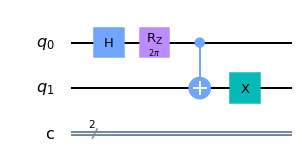

In [6]:
#Step 2 -- Test
psi = ansatz(2.0*np.pi)
%matplotlib inline
psi.draw(output='mpl')

In [7]:
#Hepler Function - Change the basis state to Z basis since QC can measure in that basis, for X we do inverse Hadamard
# and for Y we do a inverse Y
def measure_circ(psi,measure):
    if measure == 'XX':
        psi.u2(0, np.pi, 0)
        psi.u2(0, np.pi, 1)
        psi.measure((0,1),(0,1))
    elif measure == 'ZZ':
        psi.measure((0,1),(0,1))
    elif measure == 'YY':
        psi.u2(0, np.pi/2, 0)
        psi.u2(0, np.pi/2, 1)
        psi.measure((0,1),(0,1))
    else:
         raise ValueError('Input is incorrect"')
    return psi

In [8]:
#Helper Function - Get the value for a key in dictionary
def get_count(d,k):
    if k in d:
        return d[k]
    else:
        return 0

In [9]:
#Helper function - Get the expected value for each Pauli term from the circuit
#The expectation value formula is 1/N*((N00 + N11) - (N01 + N10)) since 2 qubit system can have only 4 states 00,01,10,11
# and exp = 1/N*( N00 <00|Z⊗Z|00> + N11 <11|Z⊗Z|11> + N01 <01|Z⊗Z|01> + N10 <10|Z⊗Z|10>)
# and <00|Z⊗Z|00> = <11|Z⊗Z|11> = 1 & <01|Z⊗Z|01> = <10|Z⊗Z|10> = -1

from qiskit import Aer,execute
def expect_val(theta, measure):
    # measure in the right basis, then use the counts to compute the expectation value.
    circuit = ansatz(theta)
    if measure == 'II':
        return 1
    else:
        circuit = measure_circ(circuit,measure)
    
    shots = 1024
    backend = Aer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    expectation_value = ((get_count(counts, '00')+get_count(counts, '11')) - 
                         (get_count(counts,'10')+get_count(counts, '01'))) / shots

    return expectation_value

In [10]:
#Helper function - Get the expected value for all the Pauli terms
def expected_result(theta,hamiltonian):
    total = 0
    for i in range(len(hamiltonian)):
        expectation = hamiltonian[i][0]*expect_val(theta,hamiltonian[i][1])
        total += expectation
    return total

In [11]:
#Step 3 => Use muliple parameters to change ansatz everytime and optimize to choose the lowest possible value to get
#lowest possible eigen value

#For Loop to Optimize
angles = np.linspace(0,2*np.pi,25)
expect = [expected_result(i,d) for i in angles]
print(min(expect))

(-2+0j)


In [12]:
#Step 3 -- Test
print("Lowest eigenvalue (calculated using Numpy)", min(np.linalg.eig(H)[0]))

#We can see that our result using VQE approximated using for-loop is close to what is calculated analytically by Numpy

Lowest eigenvalue (calculated using Numpy) (-1.9999999999999998+0j)


In [13]:
#Task 4
#Find the lowest eigenvalue of the following matrix: 
# [1 0 0 0; 
# 0 0 -1 0;
# 0 -1 0 0; 
# 0 0 0 1]

#We create the hamiltonian
H = np.array([[1,0,0,0],[0,0,-1,0],[0,-1,0,0],[0,0,0,1]], dtype=np.complex128)

#We decompose it into Pauli Matrices
p = decompose(H)

(0.5+0j) * ( I ⊗ I )
(-0.5+0j) * ( X ⊗ X )
(-0.5+0j) * ( Y ⊗ Y )
(0.5+0j) * ( Z ⊗ Z )


In [14]:
#We find the expectation

#Using for loop
angles = np.linspace(0,2*np.pi,25)
expect = [expected_result(i,p) for i in angles]
print(min(expect))

(-1+0j)


In [15]:
print("Lowest eigenvalue (calculated using Numpy)", min(np.linalg.eig(H)[0]))

Lowest eigenvalue (calculated using Numpy) (-0.9999999999999999+0j)


C:\Users\Aryan\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Angles (0-2π)')

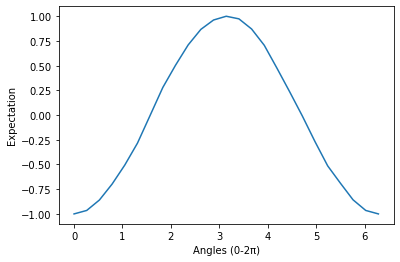

In [16]:
import matplotlib.pyplot as plt
plt.plot(angles,expect)
plt.ylabel('Expectation')
plt.xlabel('Angles (0-2π)')